In [4]:
import io
import os
import numpy as np
import glob
from IPython.display import display

from six import BytesIO

from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
import cv2

In [7]:
def load_models():
  model_detection = tf.saved_model.load('models/model_detection')
  model_classification = tf.keras.models.load_model('models/model_classification')
  return model_detection, model_classification

In [8]:
# Load the models into the notebook
model_detection, model_classification = load_models()

dients. Will likely fail if a gradient is requested.


In [30]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using tf.convert_to_tensor.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with tf.newaxis.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

  return output_dict

In [15]:
classes = { 0:'Vitesse limite 20km h',
            1:'Vitesse limite 30km h', 
            2:'Vitesse limite 50km h', 
            3:'Vitesse limite 60km h', 
            4:'Vitesse limite 70km h', 
            5:'Vitesse limite 80km h', 
            6:'Fin de limite de vitesse 80kmh', 
            7:'Vitesse limite 100km h', 
            8:'Vitesse limite 120km h', 
            9:'Depassement interdit sauf 2 roues', 
            10:'Dépassement interdit pour plus de 3.5t', 
            11:'Priorite a droite a l intersection', 
            12:'Route prioritaire', 
            13:'Cedez le passage', 
            14:'Stop', 
            15:'Interdit aux vehicules', 
            16:'Vehicules de plus de 3.5t interdits', 
            17:'Sens interdit', 
            18:'Panneau danger', 
            19:'Virage dangereux a gauche', 
            20:'Virage dangereux a droite', 
            21:'Succession de virages', 
            22:'Cassis ou dos d anes', 
            23:'Route glissante', 
            24:'Chaussee retrecie par la droite', 
            25:'Travaux', 
            26:'Feux tricolore', 
            27:'Passage pieton', 
            28:'Attention enfants', 
            29:'Attention velos', 
            30:'Attention neige verglas',
            31:'Passage animaux sauvages', 
            32:'Fin de toutes interdictions', 
            33:'Direction obligatoire a droite', 
            34:'Direction obligatoire a gauche', 
            35:'Direction obligatoire tout droit', 
            36:'Direction obligatoire tout droit ou a droite', 
            37:'Direction obligatoire tout droit ou gauche', 
            38:'Contournement obligatoire par la droite', 
            39:'Contournement obligatoire par la gauche', 
            40:'Giratoire', 
            41:'Fin de l interdiction de depassement', 
            42:'Fin de l interdiction de depassement plus de 3.5t' }

In [32]:
def create_boxes(image, model, output_dict, classes, min_score=0.3, line_thickness=3, prediction=True):
  # Get each box location and prediction score
  boxes = output_dict['detection_boxes']
  scores = output_dict['detection_scores']
  scores = np.array(scores)
  # Get the index of the boxes where the score are at a certain level
  indices = np.where(scores > min_score)

  # For each index 
  for indice in indices[0]:
    # Get all data coordinates of the box
    xmin = int(1360*boxes[indice][1])
    xmax = int(1360*boxes[indice][3])
    ymin = int(800*boxes[indice][0])
    ymax = int(800*boxes[indice][2])

    # Crop the image to have only the sign and resize it to 30x30 for the classifier
    image_crop = image[ymin:ymax, xmin:xmax]
    image_crop = cv2.resize(image_crop, (30, 30))

    # Draw a rectangle around the sign
    image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), line_thickness)
    image_crop = image_crop.reshape(1, 30, 30, 3)

    
    if prediction == True:
      # Predict the proba of each sign 
      pred = model.predict_proba(image_crop)
      
      # Display the label predicted only if score is above 0.8
      if np.max(pred) > 0.8:
        pred_text = classes[np.argmax(pred)]

        # Display the label next to the box
        if xmax + len(pred_text) *10 > 1360:
          image = cv2.rectangle(image, (xmin - len(pred_text) *10, ymax - 20), (xmin, ymax), (255,0,0), -1)
          image = cv2.putText(image, pred_text, (xmin - len(pred_text) *10, ymax - 5), 
          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
        else:
          image = cv2.rectangle(image, (xmax, ymax), (xmax + len(pred_text) *10, ymax - 20), (255,0,0), -1)
          image = cv2.putText(image, pred_text, (xmax, ymax - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
  
  return image

In [27]:
def process_image(image_path, min_score=0.25, prediction=True):
    # Load the image, change it to RGB and resize it to 1360x800
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1360, 800))

    # Make the detection of each box on the image
    output_dict = run_inference_for_single_image(model_detection, image)

    # Display boxes for each sign and print the predicted class next to it    
    image_boxes = create_boxes(image,
    model_classification, output_dict, classes, min_score=min_score, prediction=prediction)

    # Display the image with the boxes
    display(Image.fromarray(image_boxes))

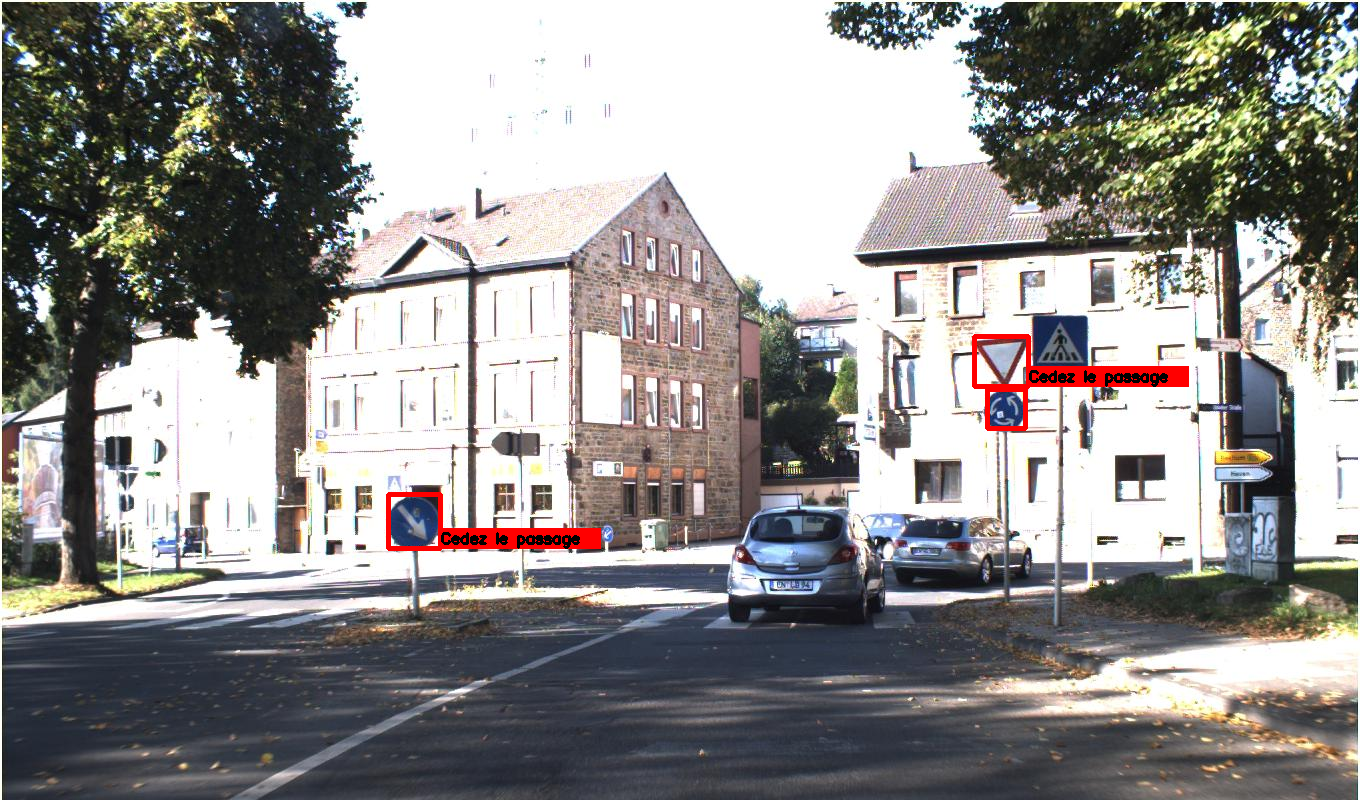

In [28]:
process_image('00001.jpeg')

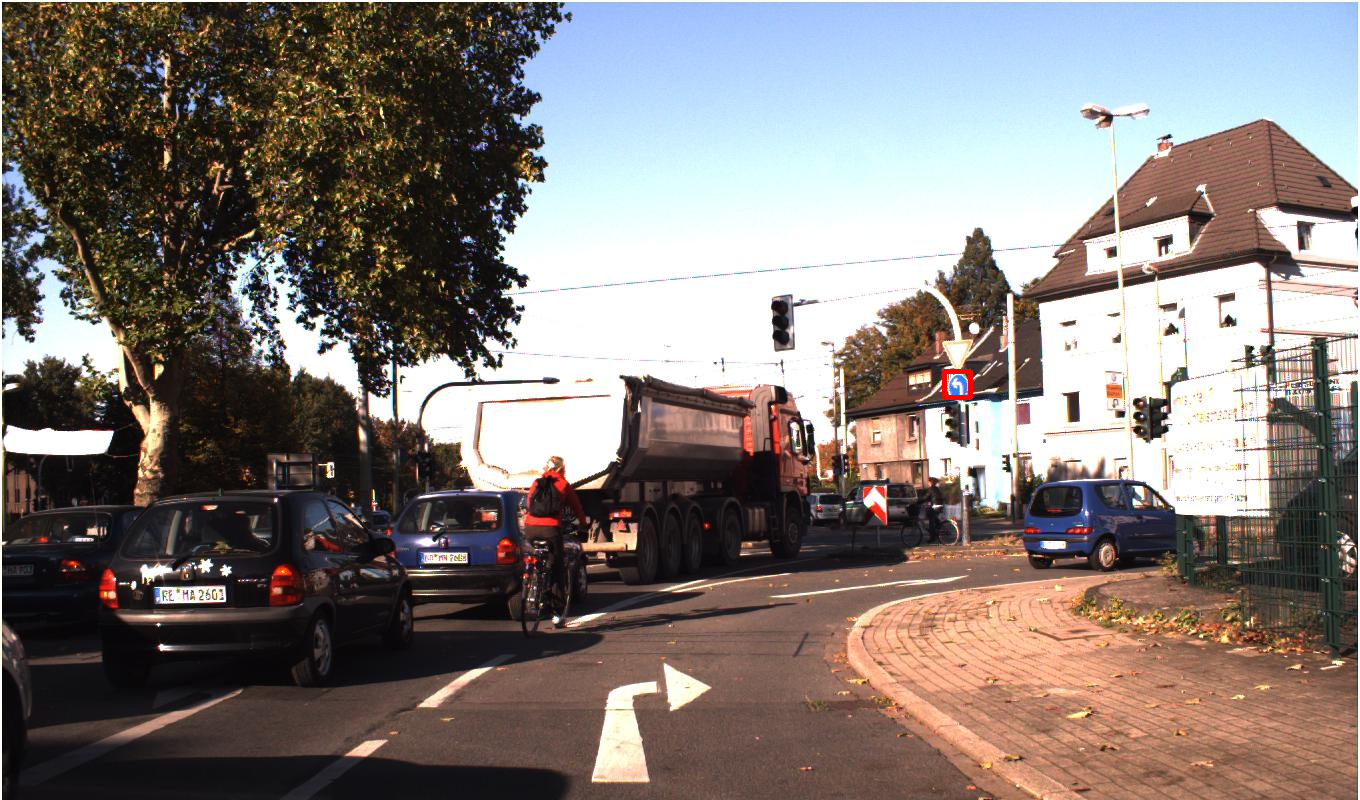

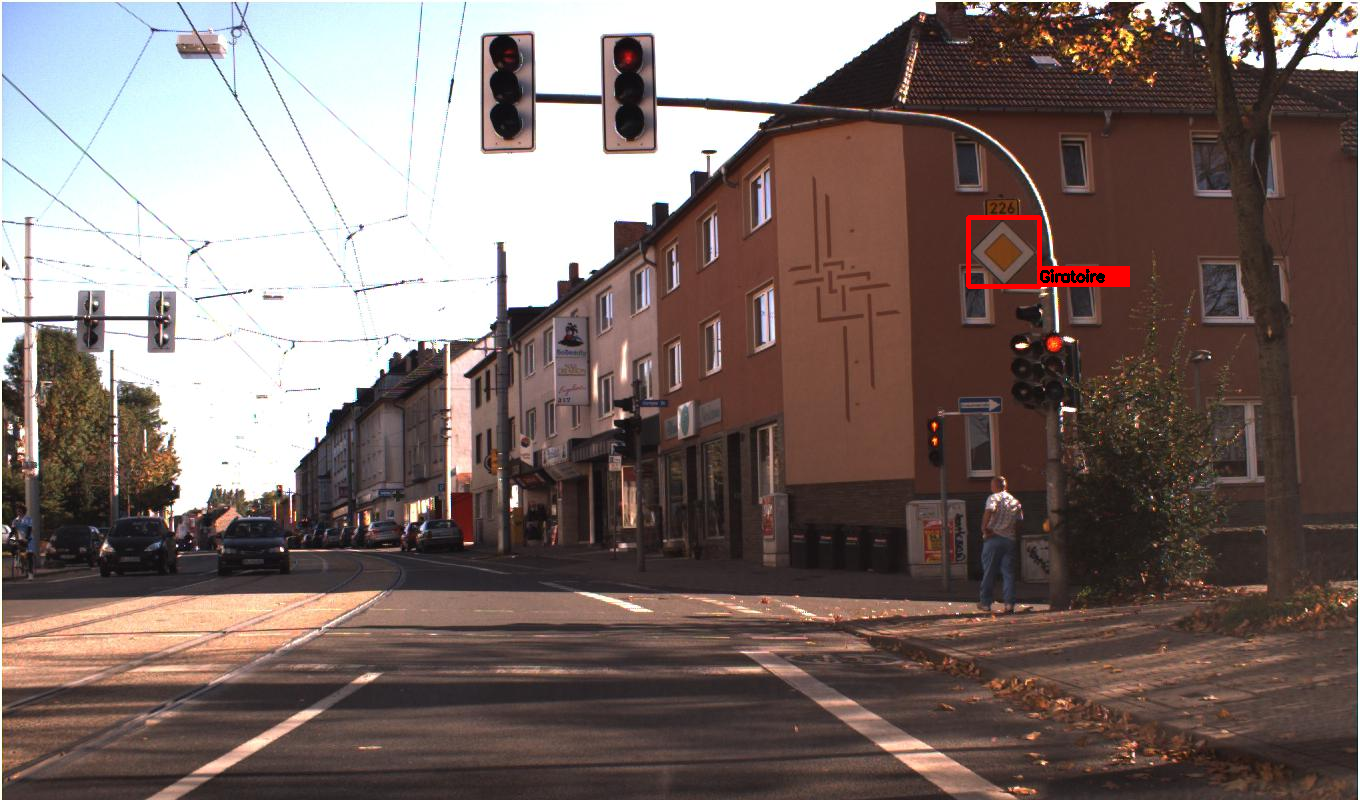

In [29]:
for i, image_path in enumerate(
      glob.glob('../tensorflow_api/models/research/object_detection/images/images/*.jpeg')):

      if i < 50:
            continue

      if i > 51:
            break
      
      process_image(image_path, min_score=0.25, prediction=True)


In [14]:
def process_video(path, model_detection, model_classification, record_name=None):
    # Run a cv2 video capture 
    cap = cv2.VideoCapture(path)
    
    # If we specify a record path it will record the video
    if record_name:
        result = cv2.VideoWriter(record_name,  cv2.VideoWriter_fourcc(*'MJPG'), 15, (1360, 800)) 
    
    while True:
        # Get the status and the frame
        ret, image = cap.read()
        # If the status is ongoing run the models on the frame and display it
        if ret == True:
            output_dict = run_inference_for_single_image(model_detection, image)

            image = create_boxes(cv2.resize(image, (1360, 800)), 
            model_classification, output_dict, classes, min_score=0.3, prediction=True)
                        
            cv2.imshow('detect', image)
            result.write(image)  
            # If "q" is pressed, exit the window
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        # If the video ended, exit the window
        else:
            break

    cap.release()
    if record_name:
        result.release()
    cv2.destroyAllWindows() 

process_video('test11.mp4', model_detection, model_classification, 'output11.avi')